# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

Note: some explanation of the theory is taken from sklearn documentation. 

In [72]:
# Import libraries necessary for this project
import collections
import operator

import numpy as np
import pandas as pd
import renders as rs

from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.mixture import GMM
from sklearn.decomposition import PCA


from sklearn.metrics import silhouette_samples, silhouette_score

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [73]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [74]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [1, 50, 200]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,7057,9810,9568,1762,3293,1776
1,6269,1095,1980,3860,609,2162
2,3067,13240,23127,3941,9959,731


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

First sample (index 0) is the in the top 25% in the whole dataset in terms of Milk, Grocery,And Delicatessen. It is around the 50% mark in terms of Fresh and Frozen. It could probably be a "high-end" (medium/small) retail center. 

Second sample (index 1) is around the 50% mark median in term of fresh. It is on the low end in terms of milk, grocery. However, it is in the top 25% both in terms of Frozen and Delicatessen. It can be a retail center specialized in "high end far east" (frozen, but delicatessen) products. 

Third sample (index 2) is the top in terms of Milk, Grocery, Frozen, Detergents_Paper. It is in the bottom ~40% of Delicatessen. It could probably be a supermarket. 



### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [75]:
#for selected_column in ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicatessen']:
selected_column = 'Detergents_Paper' #winner                        
new_data = data.drop([selected_column], axis = 1, inplace = False)
new_target = data[selected_column]

X_train, X_test, y_train, y_test = train_test_split(new_data, new_target, test_size=0.25, random_state =1)

regressor = DecisionTreeRegressor(random_state=1)
regressor.fit(X_train, y_train)

score = cross_val_score(regressor, X_test, y_test)

print "Selected column {} score {} ".format(selected_column, score)

Selected column Detergents_Paper score [ 0.87179059  0.71918794  0.7071405 ] 


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  

**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

From all the cross validation score (R^2), using Detergents_Paper has the highest (the most chance Detergents_paper can be deduced from other features). 
The results from different runs range from 0.71 to 0.87, which is a relatively good predictor. 
If the data is very large and feature removal is important, this feature can be considered to be removed (not utmost necessary for identifying customers' spending habits, since it can be relatively well deduced from other features).

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

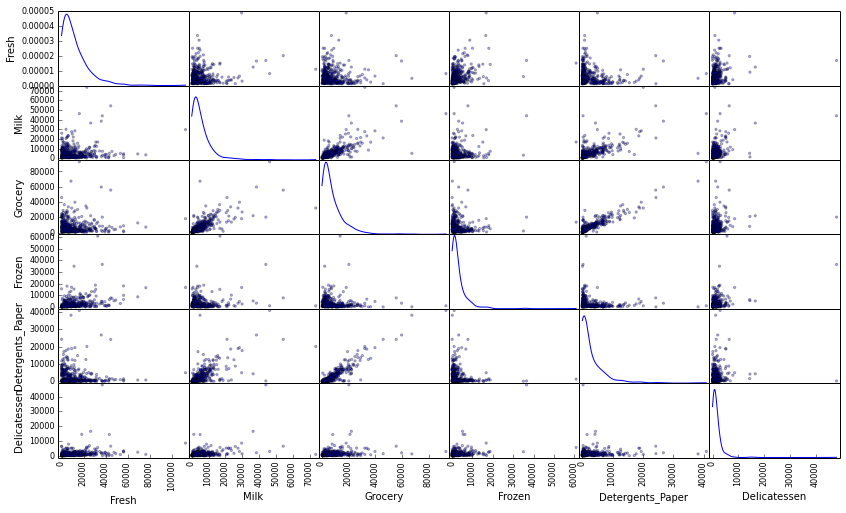

In [76]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

From the scatter graph above, correlations can be found between Grocery and Detergents_Paper. These 2 features (Detergents_Paper and Grocery, in decreasing order) have the highest cross validation score when being using as the "target" data. This confirms the cross validation score from previous assignment. (I didn't really make a prediction, i just ran the data on all columns and find the highest). 
The data for Detergents_Paper is most densed in the range from 0 to around 11000. Above that range, there are only a couple of outliers. 
The data for Grocery is most densed in the range from 0 to around 20000. Above that range, there are only a couple of outliers. 

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

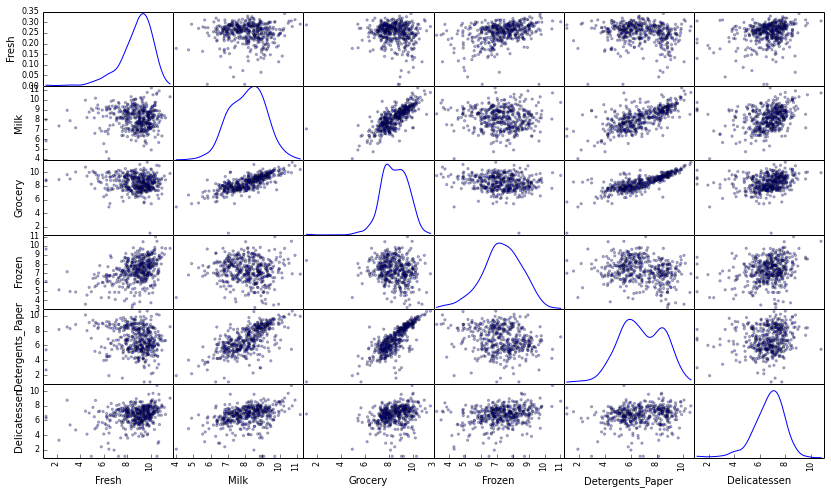

In [77]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples) #not used anyway? 

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [78]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
1,8.743372,6.998510,7.590852,8.258422,6.411818,7.678789
2,8.028455,9.490998,10.048756,8.279190,9.206232,6.594413


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [80]:
# For each feature find the data points with extreme high or low values
outlier_candidates = {}
for feature in log_data.keys():
    
    Q1 = log_data[feature].quantile(0.25)
    Q3 = log_data[feature].quantile(0.75)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    for index in log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index.tolist():
        if index in outlier_candidates:
            outlier_candidates[index] += 1
        else: 
            outlier_candidates[index] = 1


outlier_candidates = {key:value for key,value in outlier_candidates.items() if value >1}

#outlier_candidates = sorted(outlier_candidates.items(), key = operator.itemgetter(1), reverse=True)

# OPTIONAL: Select the indices for data points you wish to remove
print outlier_candidates

#outliers  = list(outlier_candidates) #be strict to any outlier
outliers = [key for key,value in outlier_candidates.items()]
print "Outliers of more than 1 features ", outliers
# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)



Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


{128: 2, 65: 2, 154: 3, 75: 2, 66: 2}
Outliers of more than 1 features  [128, 65, 154, 75, 66]


### Question 4
*Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

There are 5 data points that are outlier from more than 1 feature. (1 item: index 154 is outlier of 3 features). 
It is decided to remove the outliers that are outliers from more than 1 feature: 
1. Being outliers of more than 1 features mean it has less chance of being an outlier by mistake. 
2. The total of outliers being removed is only 5 (~1%) of the total data, which is a reasonable number.   



## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

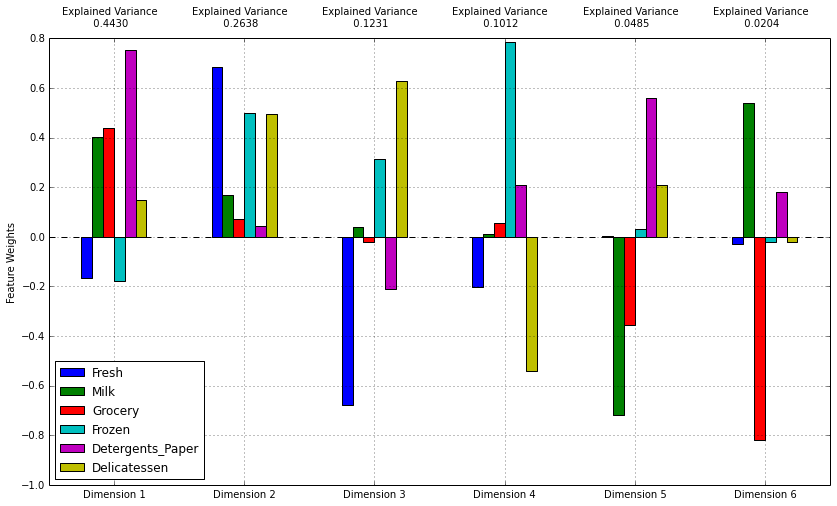

In [81]:
# TODO: Apply PCA to the good data with the same number of dimensions as features
nr_keep_components = 6
pca = PCA(n_components = nr_keep_components)
pca.fit(good_data)

# TODO: Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)


### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

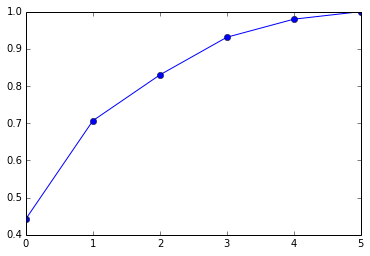

In [82]:
import matplotlib.pyplot as plt
x = np.arange(nr_keep_components)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), '-o')

(Thanks to suggestion from the first reviewer, the graph above shows the cummulative explained variance of the first X components). 
** Explained variance**

The first principle component "Detergents_Paper" explained for 0.443 variance in the data. 
The second principle component "Fresh" explained for 0.2638 variance in the data. In total the first 2 principle components explained for 0.7068 variance in the data. (Y value of X = 1 in the graph)

The first 4 principle components (Detergents_Paper, Fresh, Delicatessen, Frozen) explains for 0.9311 variance of the total data. That means the first 4 principle components account for most of the variance in the customer spending data. (Y value of X = 3 in the graph)

The other 2 components (Milk and Grocery) have low variance and can be used for dimensionality reduction. These 2 components, in other words, do not have added values when we already have the other 4 components.  

** First four dimensions and relations to customer spending **
Data are in order 
    [Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicatessen]

**First dimension**
-0.16746374  0.40143866  0.43811142 -0.17820975  0.75142613  0.14987105

The first principal axe "skewed" the most (0.75) to the direction of the dollar spent on Detergent paper, next Grocery (0.43) and Milk (0.40), then Delicatessen (0.149).

**Second dimension**
 0.68593522  0.16722783  0.07072902  0.50054207  0.04244398  0.49414702]
 
The second principle axe "skewed" the most in term of Fresh product (0.686), then Frozen (0.5) and Delicatessen (0.495). Dollars spent on Milk (0.17), Grocery (0.07) and Detergents_Paper are barely taken into account in the second principle axe. 

**Third dimension**
 [-0.67738927  0.04020501 -0.01953317  0.31504299 -0.21170161  0.62855082]

Money spent on Fresh has the most impact on the direction of the third principle axe, but in a negative way. Delicatessen has the second most impact (0.628), follow by Frozen (0.315) and Detergents_Paper (-0.21). Milk and Grocery has neligible impact. 

**Forth dimension**
 [-0.204293    0.01281068  0.05567564  0.78544905  0.20961368 -0.54233972]

Money spend on Frozen has the most impact on the direction of the fourth principle axe (0.78), followed by Delicatessen (-0.54), and Detergents_Paper (0.209) and Fresh (-0.2). Milk and Grocery have neligible impact. 

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [83]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,1.7887,0.8123,0.2315,-0.0036,-0.1194,0.2106
1,-1.1404,0.6710,0.9823,0.0603,1.1423,-0.0055
2,2.9903,0.3645,0.2521,1.5653,-0.1922,-0.1244


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [84]:
# TODO: Fit PCA to the good data using only two dimensions
pca = PCA(n_components = 2)
pca.fit(good_data)

# TODO: Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# TODO: Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [85]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,1.7887,0.8123
1,-1.1404,0.6710
2,2.9903,0.3645


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

The advantages to using a K-Means clustering algorithm are: 
1. Scales well to large number of samples.
2. Uses accross a large range of appliction areas in many different fields. 
3. Often converge fast (but can give local minimum)
4. work well with similar variance data (similar among features)

The advantages to using a Gaussian Mixture Model clustering algorithm are: 
1. Flexible (in choosing the component distributions)
2. Generalize K-means clustering model to include both variance of the data and center of the latent gaussians. 

The main difference between K-means clustering and Gaussian Mixture Model is that K-means employ hard assignment of each data point to a certain cluster after each iteration. Gussian Mixture Model will begin with weight for each assignment (e.g. 10% cluster 1, 30% cluster 2, 60% cluster 3...) and revise the weight and time goes by. 

Gaussian Mixture Model is therefore more flexible and robust. Also we will choose 2 principle components for our analysis. Using GMM shall allow each principle component to have their own Guassian distribution. 
Therefore we will use Gaussian Mixture Model for our analysis. 

K-Means is faster and more scalable. For our small dataset it is not a big issue however. 


### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [86]:
# TODO: Apply your clustering algorithm of choice to the reduced data 

def calculate_clusters(k):
    clusterer = GMM(n_components=k, n_iter=100)

    clusterer.fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    centers = clusterer.means_

    #print "Cluster centers " , centers
    sample_preds = clusterer.predict(pca_samples)
    #print "Cluster prediction of chosen samples ", sample_preds

    score = silhouette_score(reduced_data, preds)
    print "Silhouette score is {} for {} number of components".format(score , k)
    return (clusterer, preds, centers, sample_preds, score)
    
silhouette_max = 0
nr_components_max_score = 0

for k in range(2,7):
    (clusterer, preds, centers, sample_preds, score) = calculate_clusters(k)
    if score > silhouette_max: 
        silhouette_max = score
        nr_components_max_score = k
        
#store variables for use in next questions
(clusterer, preds, centers, sample_preds, score) = calculate_clusters(nr_components_max_score)

print "Best silhouette score {} for {} number of components".format(silhouette_max , nr_components)

Silhouette score is 0.411818864386 for 2 number of components
Silhouette score is 0.376166165091 for 3 number of components
Silhouette score is 0.333312614888 for 4 number of components
Silhouette score is 0.280983407051 for 5 number of components
Silhouette score is 0.27353716216 for 6 number of components
Silhouette score is 0.411818864386 for 2 number of components
Best silhouette score 0.411818864386 for 4 number of components


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

From the output above it shows number of clusters = **2** has the best Silhouette score (0.412)



### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

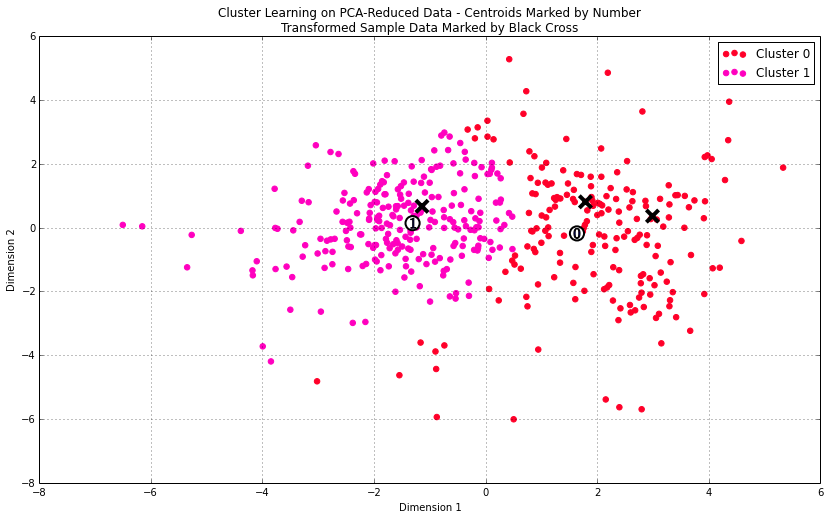

In [87]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [88]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,4316,6347,9555,1036,3046,945
Segment 1,8812,2052,2689,2058,337,712


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

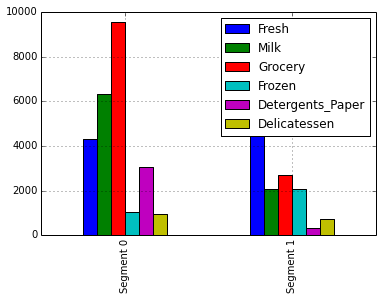

In [89]:
true_centers.plot(kind = 'bar')

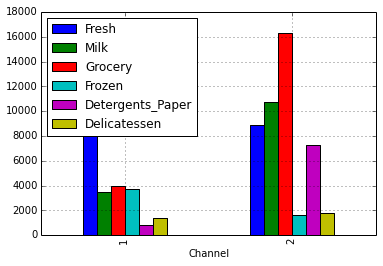

In [90]:
all_data = pd.read_csv("customers.csv")
all_data.drop(['Region'], axis = 1, inplace = True)
all_means = all_data.groupby(['Channel']).mean()
all_means.plot(kind='bar')


**Answer:**

The segment 0, 1 output from the GMM clustering algirthm could best present the "Channel" feature (["Horeca", "Retail"])in the original data set. 

From the 2 graphs above, we observe: 
1. Segment 0 correlates with Channel 2 in the original data set.
2. Segment 1 correlates with Channel 1 in the original data set.

Cluster/Segment 0 's true center has the highest amount of Fresh, Milk and Grocery (~ 4000, 6000, and 10000 respectively) could best represent "Retail" (supermarket) establishment. 

Cluster/Segment 1 's true center has the highest amount of Fresh (8000), the rest lower than segment 1 could best represent "Horeca" establishment, since they often need fresh product. 

(I don't see the benefit of comparing true_center to the original data set description without grouping by "Channel". Do i see something wrong?)



### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


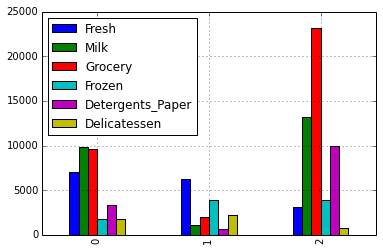

In [91]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred
    
samples.plot(kind='bar')

**Answer:**
Comparing the true center plot in question 8 and the sample point plot about: 
1. Sample point 0 could either match to cluster 0 or 1 (looks more match to 0). It is predicted to be in cluster 0 (Retail) because of high amount in Milk and Grocery. 
2. Sample point 1 best matches cluster 1. It is also predicted to be in cluster 1 (Horeca). 
3. Sample point 2 clearly best matches cluster 0 (Retail/ Supermarket) because of high amount of Grocery and Milk. It is also correctly predicted to be in cluster 0. 

## Conclusion

### Question 10
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?*  
**Hint:** Would such a change in the delivery service affect all customers equally? How could the distributor identify who it affects the most?

**Answer:**
Products like Fresh, Milk, Grocery, and Delicatessen often need frequent stocking (e.g. prefer 5 days per week shipping to 3 days per week shipping). 
The remaining products (Frozen, Detergents_Paper) can be kept for longer and be less sensitive to infrequent delivery (unless the retail center/ restaurent has a very small shelf/ warehouse). 
Furthermore, customers who purchase a small number of amount are either smaller or have limited storage space, or have different types of need. 

I would recommend to cluster (segment)  the data based on the features (products) where the constant supply of data is essential. We can then create 2 different clusters (which more focus on the features which could be most impacted by the changed delivery frequency). 

Assume after the clustering, we determine: 
1. Cluster 0 are the customers with the highest amount of Fresh, Milk, Grocery and Delicatessen. 
2. Cluster 1 are the cusmters with the lower amount of Fresh, Milk, Grocey and Delicatessen.

We should run the following A/B tests. A: 5 days per week delivery. B 3 days per week delivery. Experiment variable: satisfaction of client with the delivery. 

1. Control group: set of randomized customers. Test group: set of cluster 0 (more fresh). The satisfaction of test group  When we change delivery from 5 days (A) to 3 days (B) per week, the disatisfaction of the test group should increase. 
2. Control group: set of randomized customers. Test group: set of cluster 1 (less fresh). When we change delivery from 5 days (A) to 3 days (B) per week, the satisfaction of the test group should stay the same. 





### Question 11
*Assume the wholesale distributor wanted to predict some other feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the data to assist a supervised learning analysis?*

**Answer:**

One of the techniques mentioned earlier in the assignment is to use one of the existing feature as the "target" data for supervised learning. This feature should be removed from the original features set (used only as target for supervised learning.) This feature can be used to train the supervised machine learning model. 

Furthermore, the wholesale distributor can use the cluster information for the supervised machine learning process: 

We can use the Mean Square Error between the feature we want to predict (either new or old) against the Mean of all data in the same cluster as a Performance Metric to train our supervised model. The cluster information is one of the data column use to train the supervised learner. The predicted value of new customers versus the mean value of all customers in the same cluster should be minimized (using the performance metrics). 


### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

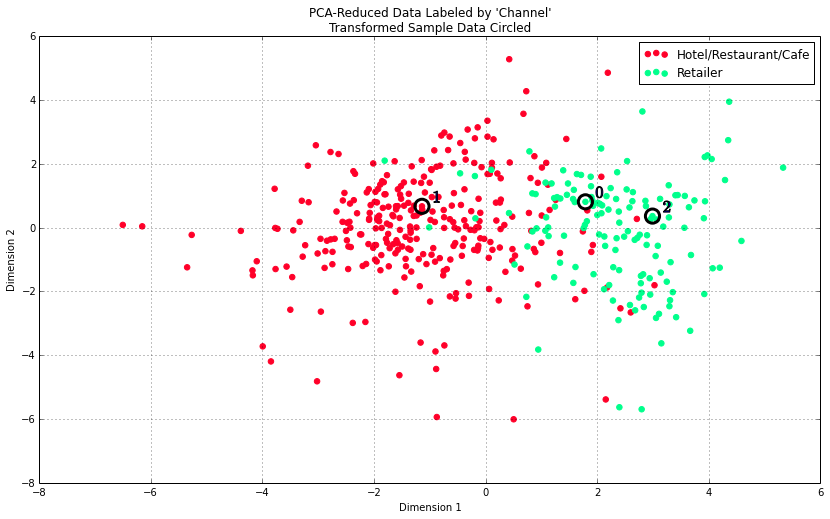

In [92]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

Comparing between graph in "Cluster visualization" and the graph above: 
* Cluster 0 match well with "Retailer" channel in the original data set
* Cluster 1 match well with "Hotel/Restaurant/Cafe" in the original data set, except for
* ** However, there are a high number of Horeca data samples penetrating in the "Retailer" space, which is not assign as such (to cluster 1) in the cluster algorithm. These clients may need "special attention" as well when doing the data set . That could also explain why our mean Silhouette score is only around 0.41.**


Also, as explained earlier, the means (group_by segment) of the first principle component (detergent_paper) match well with the mean of the cluster. 


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.